# 多层感知机

ReLU: $ReLu(x) = max(x,0)$

In [4]:
import torch
import numpy
import matplotlib.pylab as plt
import sys
import d2lzh_pytorch as d2l

def xyplot(x_vals, y_vals, name):
    plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(name)

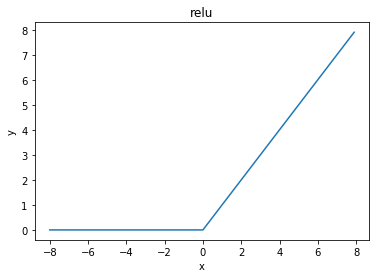

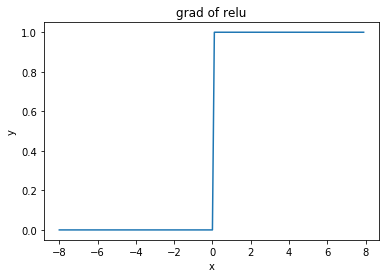

In [7]:
x = torch.arange(-8, 8, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')
plt.show()
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')
plt.show()

sigmoid: $$sigmoid(x)=\frac{1}{1+exp(-x)}$$

$$sigmoid'(x)=sigmoid(x)(1-sigmoid(x))$$

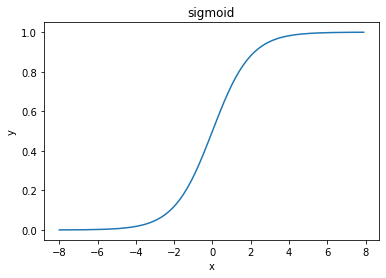

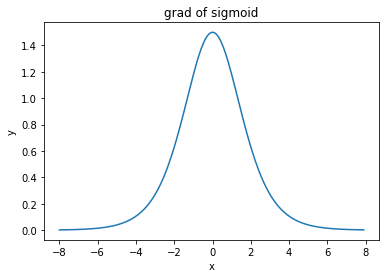

In [16]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')
plt.show()
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')
plt.show()

tanh:
$$tanh(x) = \frac{1-exp(-2x)}{1+exp(-2x)}$$

$$tanh'(x) = 1-tanh^{2}(x)$$

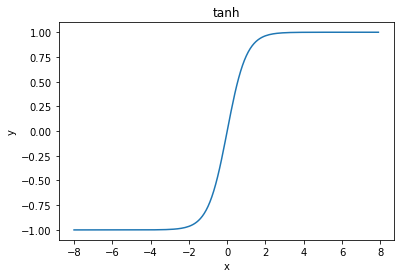

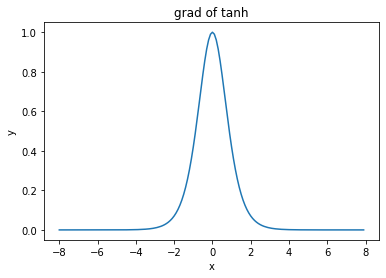

In [18]:
y = x.tanh()
xyplot(x, y, 'tanh')
plt.show()
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')
plt.show()

多层感知机公式:

$$H = \phi(XW_h + b_h),$$

$$O = HW_o + b_o$$

## 手写多层感知机

In [81]:
import torch
import numpy as np
import d2lzh_pytorch as d2l
from torch import nn
import funcs as jackFunc
from torch.nn import init
import matplotlib.pylab as plt

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

#### 定义模型参数

In [3]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, .01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, .01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(True)
    
# relu
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

#### 定义网络

In [26]:
def net(X):
    X = X.view((-1,num_inputs))
    H = relu(torch.mm(X, W1) + b1)
    O = torch.mm(H, W2) + b2
    return O

loss = nn.CrossEntropyLoss()

def sgd(params, lr, batch_size):
    # 为了和原书保持一致，这里除以了batch_size，但是应该是不用除的，因为一般用PyTorch计算loss时就默认已经
    # 沿batch维求了平均了。
    for param in params:
        param.data -= lr * param.grad # 注意这里更改param时用的param.data

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum/n

def train_ch3(net, train_iter, test_iter, 
              loss, num_epochs, batch_size, 
              params=None, lr=None, optimizer=None):
    nn = 0
    total_epochs = []
    total_loss = []
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            # 计算梯度
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()
                
            train_loss_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1) == y).float().sum().item()
            n+=y.shape[0]
            nn+=1
            
        test_acc = evaluate_accuracy(test_iter, net)
        total_epochs.append(epoch+1)
        total_loss.append(train_loss_sum/nn)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
             % (epoch+1, train_loss_sum/nn, train_acc_sum/n, test_acc))
    return total_epochs, total_loss

In [29]:
num_epochs = 2
lr = 0.5

p, pp = train_ch3(net, train_iter, test_iter, 
                  loss, num_epochs, batch_size, 
                  params, lr)

epoch 1, loss 0.3686, train acc 0.863, test acc 0.837
epoch 2, loss 0.1749, train acc 0.870, test acc 0.846


## 多层感知机的简洁实现

In [44]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

net = nn.Sequential()
net.add_module('flatten', nn.Flatten())
net.add_module('linear1', nn.Linear(num_inputs, num_hiddens))
net.add_module('relu', nn.ReLU())
net.add_module('linear2', nn.Linear(num_hiddens, num_outputs))

for params in net.parameters():
    init.normal_(params, 0, 0.01)
    print(params.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


In [45]:
batch_size = 256
lr = 0.5
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [47]:
num_epochs = 5
p, pp = train_ch3(net, train_iter, test_iter, loss, 
          num_epochs, batch_size, None,
         None, optimizer)

epoch 1, loss 0.3983, train acc 0.852, test acc 0.837
epoch 2, loss 0.1849, train acc 0.863, test acc 0.841
epoch 3, loss 0.1181, train acc 0.871, test acc 0.856
epoch 4, loss 0.0842, train acc 0.876, test acc 0.847
epoch 5, loss 0.0654, train acc 0.879, test acc 0.825


In [79]:
num_epochs = 7
total_epochs, total_loss = [], []
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

num_inputs, num_outputs = 784, 10
num_hiddens = [10, 32, 256, 1024]

net = None

for num_hidden in num_hiddens:
    net = nn.Sequential()
    net.add_module('flatten', nn.Flatten())
    net.add_module('linear1', nn.Linear(num_inputs, num_hidden))
    net.add_module('relu', nn.ReLU())
    net.add_module('linear2', nn.Linear(num_hidden, num_outputs))
    for params in net.parameters():
        init.normal_(params, 0, 0.01)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr) #****************之前忘了加了

    single_epochs, single_loss = train_ch3(net, train_iter, test_iter, loss, 
          num_epochs, batch_size, None,
         None, optimizer)
    total_epochs.append(single_epochs)
    total_loss.append(single_loss)

epoch 1, loss 1.3388, train acc 0.477, test acc 0.518
epoch 2, loss 0.3738, train acc 0.709, test acc 0.749
epoch 3, loss 0.2451, train acc 0.734, test acc 0.747
epoch 4, loss 0.1628, train acc 0.767, test acc 0.754
epoch 5, loss 0.1185, train acc 0.789, test acc 0.734
epoch 6, loss 0.0955, train acc 0.798, test acc 0.753
epoch 7, loss 0.0806, train acc 0.799, test acc 0.798
epoch 1, loss 0.8526, train acc 0.679, test acc 0.803
epoch 2, loss 0.2589, train acc 0.808, test acc 0.734
epoch 3, loss 0.1567, train acc 0.827, test acc 0.810
epoch 4, loss 0.1078, train acc 0.843, test acc 0.765
epoch 5, loss 0.0821, train acc 0.850, test acc 0.820
epoch 6, loss 0.0657, train acc 0.854, test acc 0.784
epoch 7, loss 0.0548, train acc 0.859, test acc 0.846
epoch 1, loss 0.8082, train acc 0.699, test acc 0.802
epoch 2, loss 0.2452, train acc 0.819, test acc 0.771
epoch 3, loss 0.1423, train acc 0.842, test acc 0.791
epoch 4, loss 0.0983, train acc 0.855, test acc 0.822
epoch 5, loss 0.0739, train 

Text(0, 0.5, 'loss')

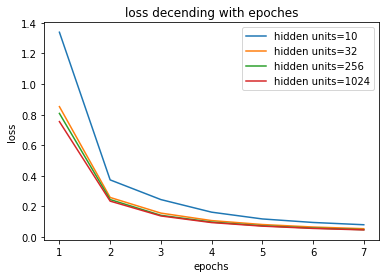

In [82]:
for i,(epoch, loss_) in enumerate(zip(total_epochs, total_loss)):
    plt.plot(epoch, loss_, label = 'hidden units='+str(num_hiddens[i]))
plt.title('loss decending with epoches')
plt.legend(loc=1)
plt.xlabel('epochs')
plt.ylabel('loss')

In [87]:
num_epochs = 7
total_epochs, total_loss = [], []
loss = nn.CrossEntropyLoss()
num_inputs, num_outputs = 784, 10
num_hiddens = 32

activates = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
activate_name = ['ReLu', 'Sigmoid', 'tanh']

for activate in activates:
    net = nn.Sequential()
    net.add_module('flatten', nn.Flatten())
    net.add_module('linear1', nn.Linear(num_inputs, num_hiddens))
    net.add_module('activate', activate)
    net.add_module('linear2', nn.Linear(num_hiddens, num_outputs))
    for params in net.parameters():
        init.normal_(params, 0, 0.01)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr) #****************之前忘了加了

    single_epochs, single_loss = train_ch3(net, train_iter, test_iter, loss, 
          num_epochs, batch_size, None,
         None, optimizer)
    total_epochs.append(single_epochs)
    total_loss.append(single_loss)

epoch 1, loss 0.9999, train acc 0.622, test acc 0.687
epoch 2, loss 0.2690, train acc 0.801, test acc 0.800
epoch 3, loss 0.1603, train acc 0.825, test acc 0.798
epoch 4, loss 0.1108, train acc 0.839, test acc 0.820
epoch 5, loss 0.0837, train acc 0.847, test acc 0.828
epoch 6, loss 0.0675, train acc 0.851, test acc 0.831
epoch 7, loss 0.0556, train acc 0.857, test acc 0.779
epoch 1, loss 1.2047, train acc 0.569, test acc 0.737
epoch 2, loss 0.3077, train acc 0.776, test acc 0.777
epoch 3, loss 0.1721, train acc 0.816, test acc 0.795
epoch 4, loss 0.1173, train acc 0.834, test acc 0.818
epoch 5, loss 0.0888, train acc 0.841, test acc 0.824
epoch 6, loss 0.0707, train acc 0.848, test acc 0.827
epoch 7, loss 0.0585, train acc 0.854, test acc 0.842
epoch 1, loss 0.7599, train acc 0.717, test acc 0.784
epoch 2, loss 0.2431, train acc 0.822, test acc 0.822
epoch 3, loss 0.1449, train acc 0.841, test acc 0.779
epoch 4, loss 0.1026, train acc 0.851, test acc 0.832
epoch 5, loss 0.0775, train 

Text(0, 0.5, 'loss')

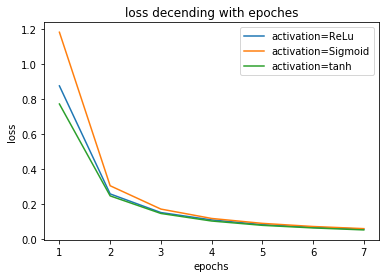

In [86]:
for i,(epoch, loss_) in enumerate(zip(total_epochs, total_loss)):
    plt.plot(epoch, loss_, label = 'activation='+activate_name[i])
plt.title('loss decending with epoches')
plt.legend(loc=1)
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

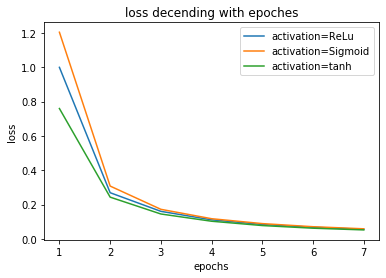

In [88]:
for i,(epoch, loss_) in enumerate(zip(total_epochs, total_loss)):
    plt.plot(epoch, loss_, label = 'activation='+activate_name[i])
plt.title('loss decending with epoches')
plt.legend(loc=1)
plt.xlabel('epochs')
plt.ylabel('loss')

事实证明Sigmoid收敛还是慢，做了两次都一样

# 多项式函数拟合实验 验证欠拟合与过拟合

In [89]:
import torch
import numpy as np
import sys
import d2lzh_pytorch as d2l
import matplotlib.pylab as plt

模拟一个函数:

$$y = 1.2x- 3.4x^2 + 5.6x^3 + 5 + \epsilon$$

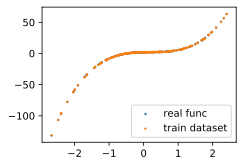

In [202]:
true_w, true_b = [1.2, -3.4, 5.6], 2
n_train, n_test = 100, 100

features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)
labels = (true_w[0]*poly_features[:,0]+true_w[1]*poly_features[:,1]+true_w[2]*poly_features[:,2]+true_b)
true_answer = labels.clone().detach()
labels += torch.tensor(np.random.normal(0, 0.3, size=labels.size()), dtype=torch.float)
plt.scatter(features, true_answer, 2, label='real func')
plt.scatter(features, labels, 2, label='train dataset')
plt.legend(loc=4)

In [205]:
num_epochs = 100
loss = torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    batch_size = min(10,train_features.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
    train_loss, test_loss = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_loss.append(loss(net(train_features), train_labels).item())
        test_loss.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_loss[-1], 'test loss', test_loss[-1])
    d2l.semilogy(range(1, num_epochs+1), train_loss, 'epochs','loss',
                range(1, num_epochs+1), test_loss, ['train', 'test'])
    print('weight:', net.weight.data.view(-1).numpy(), 
          '\ntrue_w:', true_w,
          '\nbias:', net.bias.data.item(), 
          '\nture_b:', true_b)

final epoch: train loss 0.0692327469587326 test loss 0.09746091067790985
weight: [ 1.2664855 -3.3738332  5.5763717] 
true_w: [1.2, -3.4, 5.6] 
bias: 1.9830538034439087 
ture_b: 2


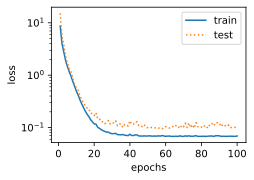

In [206]:
fit_and_plot(poly_features[:n_train,:],poly_features[n_train:, :],
             labels[:n_train],labels[n_train:])

使用线性函数拟合，会发现欠拟合

final epoch: train loss 117.30327606201172 test loss 208.2953338623047
weight: [16.56529] 
true_w: [1.2, -3.4, 5.6] 
bias: -0.6788836717605591 
ture_b: 2


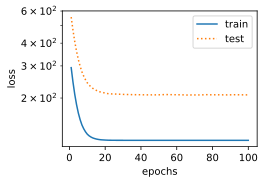

In [207]:
fit_and_plot(features[:n_train,:],features[n_train:, :],
             labels[:n_train],labels[n_train:])

使用少量样本，会过拟合

final epoch: train loss 0.5815608501434326 test loss 202.61459350585938
weight: [1.7961172 1.6950734 3.0249496] 
true_w: [1.2, -3.4, 5.6] 
bias: 0.3208264410495758 
ture_b: 2


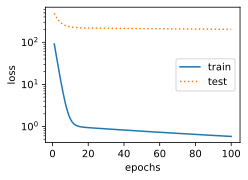

In [212]:
fit_and_plot(poly_features[:5:],poly_features[n_train:, :],
             labels[:5],labels[n_train:])

# 解决过拟合常用的方法：权重衰减

权重衰减与$L_2$范数正则化同理，惩罚模型的参数使得学出来的参数较小

线性回归损失函数：

##### $$l(w_1,w_2,b) = \frac{1}{n}\sum^{i=1}_{n}{\frac{1}{2}(x_1^{(i)}+x_2^{(i)}+b-y^{(i)})^2}$$

带有$L_2$范数惩罚项的新损失函数为：

##### $$l(w_1,w_2,b)+\frac{\lambda}{2n}|| w ||^2 $$

此时参数的迭代方式改为:

#### $$
            w_1\leftarrow(1-\frac{\eta\lambda}{|B|})w_1-\frac{\eta}{|B|}
            \sum^{}_{i \in B}{x_1^{(i)}(x_2^{(i)}w_1+x_2^{(i)}w_2+b-y^{(i)})},
            \atop
            w_2\leftarrow(1-\frac{\eta\lambda}{|B|})w_2-\frac{\eta}{|B|}
            \sum_{i\in B}{x_2^{(i)}(x_1^{(i)}w_1+x_2^{(i)}w_2+b-y^{(i)})},
      $$

## 高维线性回归使用权重衰减解决

$$y=0.05+\sum^{p}_{i=1}{0.01x_i}+\epsilon$$

#### 手写实现

torch.Size([20, 200]) torch.Size([100, 200])


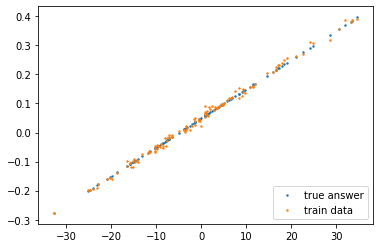

In [5]:
import torch
import torch.nn as nn
import numpy as np
import d2lzh_pytorch as d2l
import matplotlib.pylab as plt

n_train = 20
n_test = 100
num_inputs = 200
true_w, true_b = torch.ones(num_inputs, 1)*0.01, 0.05
features = torch.randn((n_train + n_test, num_inputs))
labels = torch.mm(features, true_w) + true_b
true_answer = labels.clone().detach()
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.shape), dtype=torch.float)
featureToShow = features.clone().detach()
featureToShow = featureToShow.sum(dim=1).numpy()
train_features, test_features = features[:n_train,:], features[n_train:,:]
train_labels, test_labels = labels[:n_train], labels[n_train:]
print(train_features.shape, test_features.shape)

# plot it
plt.scatter(featureToShow, true_answer, 2, label = 'true answer')
plt.scatter(featureToShow, labels, 2, label='train data')
plt.legend(loc=4)
plt.show()

In [6]:
# 加上梯度计算
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# 惩罚项
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [17]:
# start

batch_size, num_epochs, lr = 1, 100, 0.003
net = d2l.linreg
loss = d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_loss, test_loss = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_loss.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_loss.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_loss, 'epochs','loss',
                 range(1, num_epochs + 1), test_loss, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 14.20779037475586


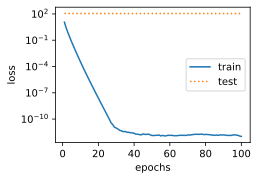

L2 norm of w: 0.038804780691862106


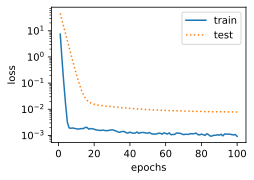

In [20]:
fit_and_plot(lambd=0)
plt.show()
fit_and_plot(lambd=5)
plt.show()

#### pyTorch实现

In [21]:
# start

batch_size, num_epochs, lr = 1, 100, 0.003

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
loss = nn.MSELoss()

def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs, 1)
    
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) #衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)
    
    train_loss, test_loss = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            w.grad.data.zero_()
            b.grad.data.zero_()
            
            l.backward()
            
            optimizer_w.step()
            optimizer_b.step()
            
        train_loss.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_loss.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_loss, 'epochs','loss',
                 range(1, num_epochs + 1), test_loss, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 13.516950607299805


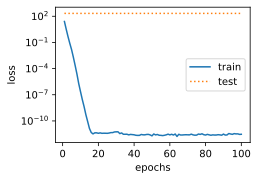

L2 norm of w: 0.04096043482422829


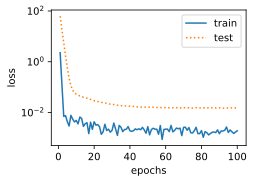

In [24]:
fit_and_plot(lambd=0)
plt.show()
fit_and_plot(lambd=10)
plt.show()

# 丢弃法 Dropout

## 函数

丢弃法使用新的隐藏单元:

$$ h^{'}_i=\frac{\xi_i}{1-p}h_i $$

并且丢弃法不改变输入的期望

## 手写实现

In [358]:
import torch
import torch.nn as nn
import numpy as np
import d2lzh_pytorch as d2l

def dropout(X, drop_prob):
    X = X.float()
    assert 0<= drop_prob <=1
    keep_prob = 1-drop_prob
    # keep=0 全部丢弃
    if keep_prob ==0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape)<keep_prob).float()
    nonzero = np.nonzero(mask)
    return mask * X / keep_prob #, nonzero.shape[0]/X.view(-1).shape[0]

* 原文这边用的是normal 标准正态分布 是错的

In [359]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.tensor(np.zeros(num_hiddens1), dtype=torch.float, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.tensor(np.zeros(num_hiddens2), dtype=torch.float, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.tensor(np.zeros(num_outputs), dtype=torch.float, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

In [368]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.mm(X, W1)+b1).relu()
    if is_training:
        # H1 = dropout(H1, drop_prob1)
        a
    H2 = (torch.mm(H1, W2)+b2).relu()
    if is_training:
        a
        # H2 = dropout(H2, drop_prob2)
    O = torch.mm(H2, W3)+b3
    return O

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, nn.Module):
            net.eval()
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train()
            
        else:
            if('is_training' in net.__code__.co_varnames):
                acc_sum += (net(X, False).argmax(dim=1)==y).float().sum().item()
            else:
                acc_sum += (net(X).argmax(dim=1)==y).float().sum().item()
        n+=y.shape[-1]
    return acc_sum / n

def train_ch3(net, train_iter, test_iter, 
              loss, num_epochs, batch_size, 
              params=None, lr=None, optimizer=None):
    nn = 0
    total_epochs = []
    total_loss = []
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            # 计算梯度
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()
                
            train_loss_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1) == y).float().sum().item()
            n+=y.shape[0]
            nn+=1
            
        test_acc = evaluate_accuracy(test_iter, net)
        total_epochs.append(epoch+1)
        total_loss.append(train_loss_sum/nn)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
             % (epoch+1, train_loss_sum/nn, train_acc_sum/n, test_acc))
    return total_epochs, total_loss

In [369]:
num_epochs, lr, batch_size = 5, 0.1, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
optimizer = torch.optim.SGD(params, lr = 0.1)

In [370]:
train_ch3(net, train_iter, test_iter,
         loss, num_epochs, batch_size,
         params, lr, optimizer)

epoch 1, loss 0.4376, train acc 0.843, test acc 0.828
epoch 2, loss 0.2068, train acc 0.851, test acc 0.843
epoch 3, loss 0.1325, train acc 0.857, test acc 0.838
epoch 4, loss 0.0959, train acc 0.861, test acc 0.844
epoch 5, loss 0.0738, train acc 0.868, test acc 0.841


([1, 2, 3, 4, 5],
 [0.43758541345596313,
  0.20678743846873018,
  0.13247093959903042,
  0.09591366030434345,
  0.07378056805184546])

就小型网络来看 不dropout没啥影响

## pyTorch实现

In [374]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.ReLU(),
    nn.Dropout(drop_prob1),
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Dropout(drop_prob2),
    nn.Linear(num_hiddens2, num_outputs),
)
for params in net.parameters():
    nn.init.normal_(params, mean=0, std=.01)
    
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

In [375]:
train_ch3(net, train_iter, test_iter,
         loss, num_epochs, batch_size,
         None, None, optimizer)

epoch 1, loss 1.1329, train acc 0.566, test acc 0.759
epoch 2, loss 0.2880, train acc 0.787, test acc 0.770
epoch 3, loss 0.1640, train acc 0.821, test acc 0.782
epoch 4, loss 0.1109, train acc 0.839, test acc 0.831
epoch 5, loss 0.0833, train acc 0.847, test acc 0.834


([1, 2, 3, 4, 5],
 [1.1328865013224014,
  0.2880264825643377,
  0.16398794295939995,
  0.11086513869305875,
  0.08331132082228965])

# 正向传播 反向传播与计算图

求梯度的链式法则：

$$\frac{\partial{Z}}{\partial{X}}=prod({\frac{\partial{Z}}{\partial{Y}}},{\frac{\partial{Y}}{\partial{X}}})$$

Xavier随机初始化

$$U(-\sqrt{\frac{6}{a+b}},\sqrt{\frac{6}{a+b}})$$